# Function to fit Lee-Carter
We use Singular Value Decomposition (SVD)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from statsmodels.tsa.arima.model import ARIMA

C:\Users\liesv\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load data

In [2]:
os.chdir("..")
MYwd= os.getcwd()
file_path = MYwd+"\Data\mortality.csv"

df = pd.read_csv(file_path)

# add a column with the mortality rates (originally, only the log_mortality rates are included)
df['mortality'] = np.exp(df['log_mortality'])

# the dataset contains data from west and east germany seperately. we only use the rates for the entire population of germany (DEUT)
df = df[(df['Country'].isin(["CHE","DEUT","DNK", "ESP", "FRATNP", "ITA", "JPN", "POL", "USA"]))]

print(df.head(10))

  Country  Year  Gender  Age  log_mortality  mortality
0     CHE  1950  Female    0      -3.601125   0.027293
1     CHE  1950  Female    1      -5.793926   0.003046
2     CHE  1950  Female    2      -6.392539   0.001674
3     CHE  1950  Female    3      -6.697494   0.001234
4     CHE  1950  Female    4      -6.900780   0.001007
5     CHE  1950  Female    5      -7.476916   0.000566
6     CHE  1950  Female    6      -7.374564   0.000627
7     CHE  1950  Female    7      -7.469874   0.000570
8     CHE  1950  Female    8      -7.492945   0.000557
9     CHE  1950  Female    9      -7.885921   0.000376


## Functions to Fit Lee-Carter
Source: https://nl.mathworks.com/help/risk/forecast-mortality-trends-using-lee-carter-model.html

The estimation is based on a Least-Squares approach. The different steps are: 
1) Fit $\alpha_x$:
$$\hat{\alpha_x} = \frac{1}{T} \sum\limits_{t} \ln(m_{x,t})$$

2) Use Singular Value Decomposition (SVD) on the residuals:

    - Time span of size T: t=0,1,2,...,T-1
    - N age groups: x=1,2,...,N
    - Create NxT residual matrix Z:

$$ Z = \ln(m_{x,t}) - \hat{\alpha_x} = U.S.V^* = \hat{b}\cdot \hat{k}' = \sum\limits_{i=1}^k  \lambda_i P_{x,i} Q_{t,i}$$
where $k=rank(Z), \lambda_i$ the singular values of $Z$ in decreasing order, $P_{x,i}$ and $Q_{t,i}$ the corresponding left and right singular vectors

The first term approximation of the SVD gives:
$$\hat{b} = P_{x,1}$$
$$\hat{\kappa} = \lambda_1 \cdot Q_{t,1}$$


Data must have the following format: 

    - rows: ages
    - columns: years

In [3]:
def fit_LC(df, correct_format = True):
    """This function fits the Lee-Carter model to the given dataframe df
    The dataframe needs a column with ages: Age, a column with years: Year and a column with log mortality rates: log_mortality
    The function returns the parameter estimates ax, bx and kt"""
    
    if not correct_format:
        # set data frame in the correct format (rows: ages, columns:years, values: log mortality)
        df = df.pivot(index='Age', columns='Year', values='log_mortality')
    
    ages = np.array(df.index)
    years = np.array(df.columns)
    
    # Estimate a_x
    ax = df.mean(axis=1)
    
    # Create the Z matrix: Z = ln(m_x,t) - ax = bx * kt
    Z = df.sub(ax, axis=0)
    
    # Perform SVD
    U, s, Vt = np.linalg.svd(Z.values, full_matrices=False)
    
    # Extract estimates for bx and kt
    bx = -U[:, 0]
    kt = -s[0] * Vt[0, :]
    
    # Satisfy constraints on parameters
    bx = bx / np.sum(bx)
    kt = (kt - np.mean(kt)) * sum(bx)
    ax = ax + bx * np.mean(kt)
    
    bx_series = pd.Series(bx, index=ages)
    kt_series = pd.Series(kt, index=years)
    ax_series = pd.Series(ax, index=ages)
    
    # Construct estimates for log_mortality = ax + bx * kt
    estimates = pd.DataFrame(index=ages, columns=years)

    for year in years:
        estimates[year] = ax_series + bx_series * kt_series[year]
    
    return ax, bx, kt, estimates


In [4]:
def forecast_LC(ax, bx, kt, forecast_years):
    """Given the fitted values for ax, bx and kt, this function calculates forecasts for the forecast_years"""

    # Fit ARIMA model on kt
    model = ARIMA(kt, order=(1,1,0))
    fit = model.fit()

    # Forecast 
    kt_forecast = fit.forecast(steps=len(forecast_years))
    kt_forecast = pd.Series(kt_forecast, index=forecast_years)
    
    # Construct forecasted matrix
    ages = np.array(ax.index)
    forecast_matrix = pd.DataFrame(index=ages, columns=forecast_years)

    for year in forecast_years:
        forecast_matrix[year] = ax + bx * kt_forecast[year]
    
    return forecast_matrix

    

## Fit for multiple countries

In [5]:
# Define training set and test set: 
train = df[(df['Year'].between(1956, 2005))]        # 50 years of data
test = df[(df['Year'].between(2006, 2016))]         # 10 years of data


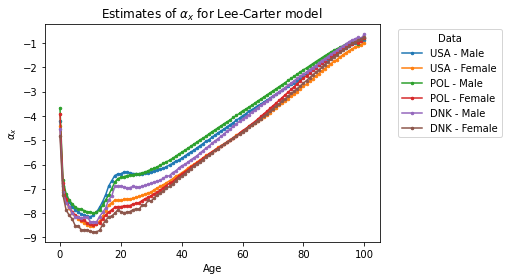

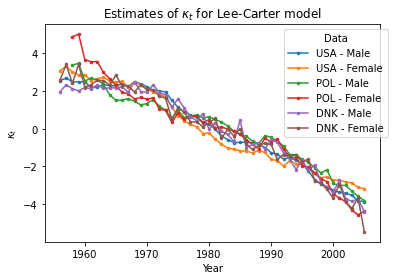

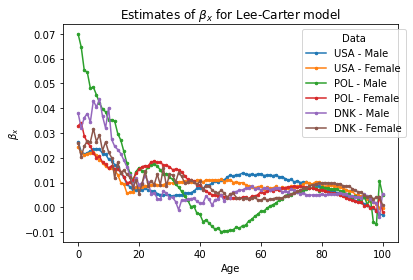

In [6]:
genders = ['Male', 'Female']
countries = ['USA', 'POL', 'DNK']

predic_results = pd.DataFrame(columns=['Country', 'Year', 'Gender', 'Age', 'predic_lnm'])

for country in countries:
    for gender in genders:
        train_set = train[(train['Gender'] == gender) & (train['Country'] == country)]
        test_set = test[(test['Gender'] == gender) & (test['Country'] == country)]
        
        # Fit Lee-Carter model:
        matrix = train_set.pivot(index='Age', columns='Year', values='log_mortality')
        
        ax, bx, kt, estimates = fit_LC(matrix)
        
        ages = np.array(matrix.index)
        years = np.array(matrix.columns)
        
        # Nice plots of the estimates
        plt.figure(1)
        plt.plot(ages, ax, marker='.', markersize=5, label=f'{country} - {gender}')
        plt.xlabel('Age')
        plt.ylabel(r'$\alpha_x$')
        plt.grid()
        plt.title(r'Estimates of $\alpha_x$ for Lee-Carter model')
        plt.legend(bbox_to_anchor=(1.04, 1), title="Data")
        
        plt.figure(2)
        plt.plot(years, kt, marker='.', markersize=5, label=f'{country} - {gender}')
        plt.xlabel('Year')
        plt.ylabel(r'$\kappa_t$')
        plt.grid()
        plt.title(r'Estimates of $\kappa_t$ for Lee-Carter model')
        plt.legend(bbox_to_anchor=(1.04, 1), title="Data")
        
        plt.figure(3)
        plt.plot(ages, bx, marker='.', markersize=5, label=f'{country} - {gender}')
        plt.xlabel('Age')
        plt.ylabel(r'$\beta_x$')
        plt.grid()
        plt.title(r'Estimates of $\beta_x$ for Lee-Carter model')
        plt.legend(bbox_to_anchor=(1.04, 1), title="Data")
        
        # Compute forecasts
        forecast_years = test_set['Year'].drop_duplicates()
        
        forecast_matrix = forecast_LC(ax, bx, kt, forecast_years)
        
        forecast_df = forecast_matrix.reset_index().melt(id_vars='index', var_name='Year', value_name='predic_lnm')
        forecast_df.rename(columns={'index':'Age'}, inplace=True)
        forecast_df['Country'] = country
        forecast_df['Gender'] = gender
        
        predic_results = pd.concat([predic_results, forecast_df], ignore_index=True)

In [7]:
results = test[(test['Country'].isin(countries))].copy()
results = pd.merge(results, predic_results, on=['Year', 'Age', 'Country', 'Gender'], how='left')

results

,Country,Year,Gender,Age,log_mortality,mortality,predic_lnm
0,DNK,2006,Female,0,-5.659574,0.003484,-4.927397
1,DNK,2006,Female,1,-8.979229,0.000126,-7.355439
2,DNK,2006,Female,2,-8.987197,0.000125,-7.972652
3,DNK,2006,Female,3,-8.746606,0.000159,-8.203944
4,DNK,2006,Female,4,-9.672376,0.000063,-8.349494
...,...,...,...,...,...,...,...
6661,USA,2016,Male,96,-1.181204,0.306909,-1.05783
6662,USA,2016,Male,97,-1.139750,0.319899,-1.000354
6663,USA,2016,Male,98,-1.004789,0.366122,-0.957529
6664,USA,2016,Male,99,-0.946588,0.388063,-0.912884


In [8]:
# Save to excel
#results.to_excel('predictions_LC_DAVdata.xlsx', index=False)